# Examining Performance vs Variables

In [25]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Add the path to the parent directory to augment search for module
sys.path.append("../..")

from short_tank_EDA.exploratory_data_analysis_utils import *

from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output
from WatChMaL.analysis.performance_analysis_utils import plot_binned_performance, multi_plot_binned_performance, deprecated_plot_binned_performance, deprecated_plot_fitqun_binned_performance

## Load Data From H5

In [28]:
# Import test events from h5 file
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_emg_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

hdf5_hit_pmt    = data_file["hit_pmt"]
hdf5_hit_time   = data_file["hit_time"]
hdf5_hit_charge = data_file["hit_charge"]


hit_pmt    = np.memmap(data_path, mode="r", shape=hdf5_hit_pmt.shape,
                                    offset=hdf5_hit_pmt.id.get_offset(), dtype=hdf5_hit_pmt.dtype)

hit_time   = np.memmap(data_path, mode="r", shape=hdf5_hit_time.shape,
                                    offset=hdf5_hit_time.id.get_offset(), dtype=hdf5_hit_time.dtype)

hit_charge = np.memmap(data_path, mode="r", shape=hdf5_hit_charge.shape,
                                    offset=hdf5_hit_charge.id.get_offset(), dtype=hdf5_hit_charge.dtype)

angles     = np.array(data_file['angles'])
energies   = np.array(data_file['energies'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])
root_files = np.array(data_file['root_files'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


## Load Indices

In [29]:
idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_3M_OD_veto_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)

train_idxs = idxs['train_idxs']
val_idxs   = idxs['val_idxs']
test_idxs  = idxs['test_idxs']

## Split Datasets

In [30]:
train_angles    = angles[train_idxs]
train_energies  = energies[train_idxs]
train_positions = positions[train_idxs]
train_labels    = labels[train_idxs]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 'angles':train_angles, 'labels':train_labels}

print("Done train info")

val_angles     = angles[val_idxs]
val_energies   = energies[val_idxs]
val_positions  = positions[val_idxs]
val_labels     = labels[val_idxs]

val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 'angles':val_angles, 'labels':val_labels}

print("Done val info")

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]
test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 'angles':test_angles, 'labels':test_labels}

print("Done test info")

Done train info
Done val info
Done test info


In [31]:
dataset_info = [train_info, val_info, test_info]

In [32]:
train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
val_g_idxs   = np.where(dataset_info[1]['labels']==0)[0]
test_g_idxs  = np.where(dataset_info[2]['labels']==0)[0]

g_idxs = np.concatenate((train_g_idxs, val_g_idxs, test_g_idxs))

train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
val_e_idxs   = np.where(dataset_info[1]['labels']==1)[0]
test_e_idxs  = np.where(dataset_info[2]['labels']==1)[0]

e_idxs = np.concatenate((train_e_idxs, val_e_idxs, test_e_idxs))

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs   = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs  = np.where(dataset_info[2]['labels']==2)[0]

m_idxs = np.concatenate((train_m_idxs, val_m_idxs, test_m_idxs))

In [33]:
# Load normal energies
train_g_energies = dataset_info[0]['energies'][train_g_idxs]
val_g_energies   = dataset_info[1]['energies'][val_g_idxs]
test_g_energies  = dataset_info[2]['energies'][test_g_idxs]

g_energies = np.concatenate((train_g_energies, val_g_energies, test_g_energies))

train_e_energies = dataset_info[0]['energies'][train_e_idxs]
val_e_energies   = dataset_info[1]['energies'][val_e_idxs]
test_e_energies  = dataset_info[2]['energies'][test_e_idxs]

e_energies = np.concatenate((train_e_energies, val_e_energies, test_e_energies))

train_m_energies = dataset_info[0]['energies'][train_m_idxs]
val_m_energies   = dataset_info[1]['energies'][val_m_idxs]
test_m_energies  = dataset_info[2]['energies'][test_m_idxs]

m_energies = np.concatenate((train_m_energies, val_m_energies, test_m_energies))

# Load Evaluation Data

In [34]:
label_dict         = {"$\gamma$":0, "$e$":1, "$\mu$":2}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$"}

muon_softmax_index_dict = {"e/gamma":0, "mu":1}

c = plt.cm.viridis(np.linspace(0,1,10)) #plt.rcParams['axes.prop_cycle'].by_key()['color']

In [35]:
############# define run locations #############
locs = ['/home/jtindall/WatChMaL/outputs/2021-03-09/ordered_od_veto/outputs',
        '/home/jtindall/WatChMaL/outputs/2021-03-09/ordered_no_veto/outputs'
        ]

titles = ['Short Tank No Veto Run 1',
          'Short Tank No Veto Run 2']

In [36]:
############# load short tank run data #############
raw_output_softmax   = [np.load(loc + "/softmax.npy") for loc in locs]
raw_actual_labels    = [np.load(loc + "/labels.npy") for loc in locs]
raw_actual_indices   = [np.load(loc + "/indices.npy") for loc in locs]

# Event Breakdown By Energy for Muons

In [37]:
d_to_wall = np.load('./performance_analysis_data/updated_OD_veto_dist_to_wall.npz', allow_pickle=True)

dataset_info[0]['d_to_wall'] = d_to_wall['train_d_to_wall']
dataset_info[1]['d_to_wall'] = d_to_wall['val_d_to_wall']
dataset_info[2]['d_to_wall'] = d_to_wall['test_d_to_wall']

print(dataset_info[2]['labels'].shape)
print(dataset_info[2]['d_to_wall'].shape)

(2756358,)
(2756358,)


In [38]:
# Load normal d_to_wall
train_g_d_to_wall = dataset_info[0]['d_to_wall'][train_g_idxs]
val_g_d_to_wall   = dataset_info[1]['d_to_wall'][val_g_idxs]
test_g_d_to_wall  = dataset_info[2]['d_to_wall'][test_g_idxs]

g_d_to_wall = np.concatenate((train_g_d_to_wall, val_g_d_to_wall, test_g_d_to_wall))

train_e_d_to_wall = dataset_info[0]['d_to_wall'][train_e_idxs]
val_e_d_to_wall   = dataset_info[1]['d_to_wall'][val_e_idxs]
test_e_d_to_wall  = dataset_info[2]['d_to_wall'][test_e_idxs]

e_d_to_wall = np.concatenate((train_e_d_to_wall, val_e_d_to_wall, test_e_d_to_wall))

train_m_d_to_wall = dataset_info[0]['d_to_wall'][train_m_idxs]
val_m_d_to_wall   = dataset_info[1]['d_to_wall'][val_m_idxs]
test_m_d_to_wall  = dataset_info[2]['d_to_wall'][test_m_idxs]

m_d_to_wall = np.concatenate((train_m_d_to_wall, val_m_d_to_wall, test_m_d_to_wall))

In [39]:
test_idxs       = test_idxs
test_energies   = dataset_info[2]['energies']
test_d_to_wall  = dataset_info[2]['d_to_wall']

# bin energy data
energy_hist, energy_bins = np.histogram(test_energies, bins=9)
print("Energy bins: ", energy_bins)

# bin d to wall data
d_to_wall_hist, d_to_wall_bins = np.histogram(test_d_to_wall, bins=9)
print("Distance to wall bins: ", d_to_wall_bins)

Energy bins:  [   1.3268762  130.09647    258.86606    387.63565    516.4052
  645.1748     773.9444     902.714     1031.4836    1160.2532   ]
Distance to wall bins:  [2.82029219e-02 1.10107810e+02 2.20187416e+02 3.30267023e+02
 4.40346630e+02 5.50426237e+02 6.60505843e+02 7.70585450e+02
 8.80665057e+02 9.90744663e+02]


## Plot No Veto Results

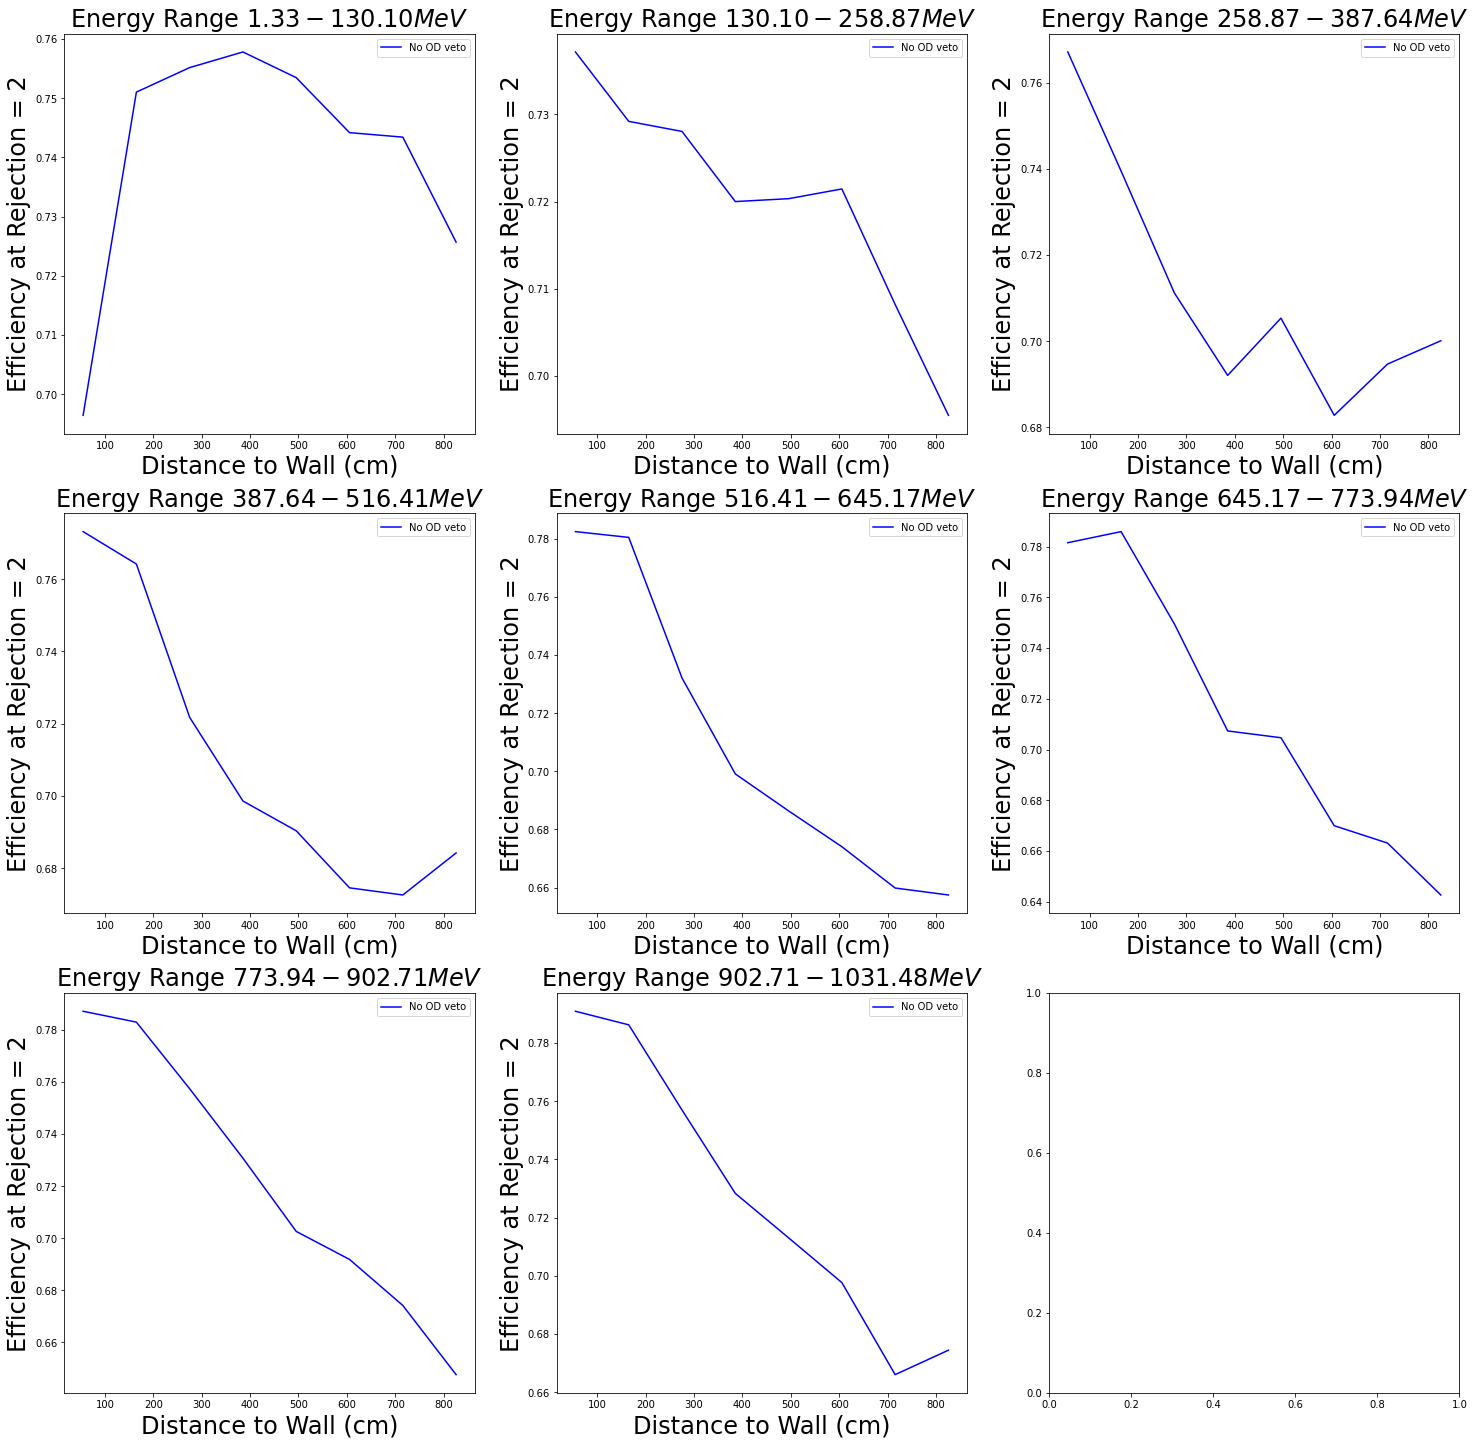

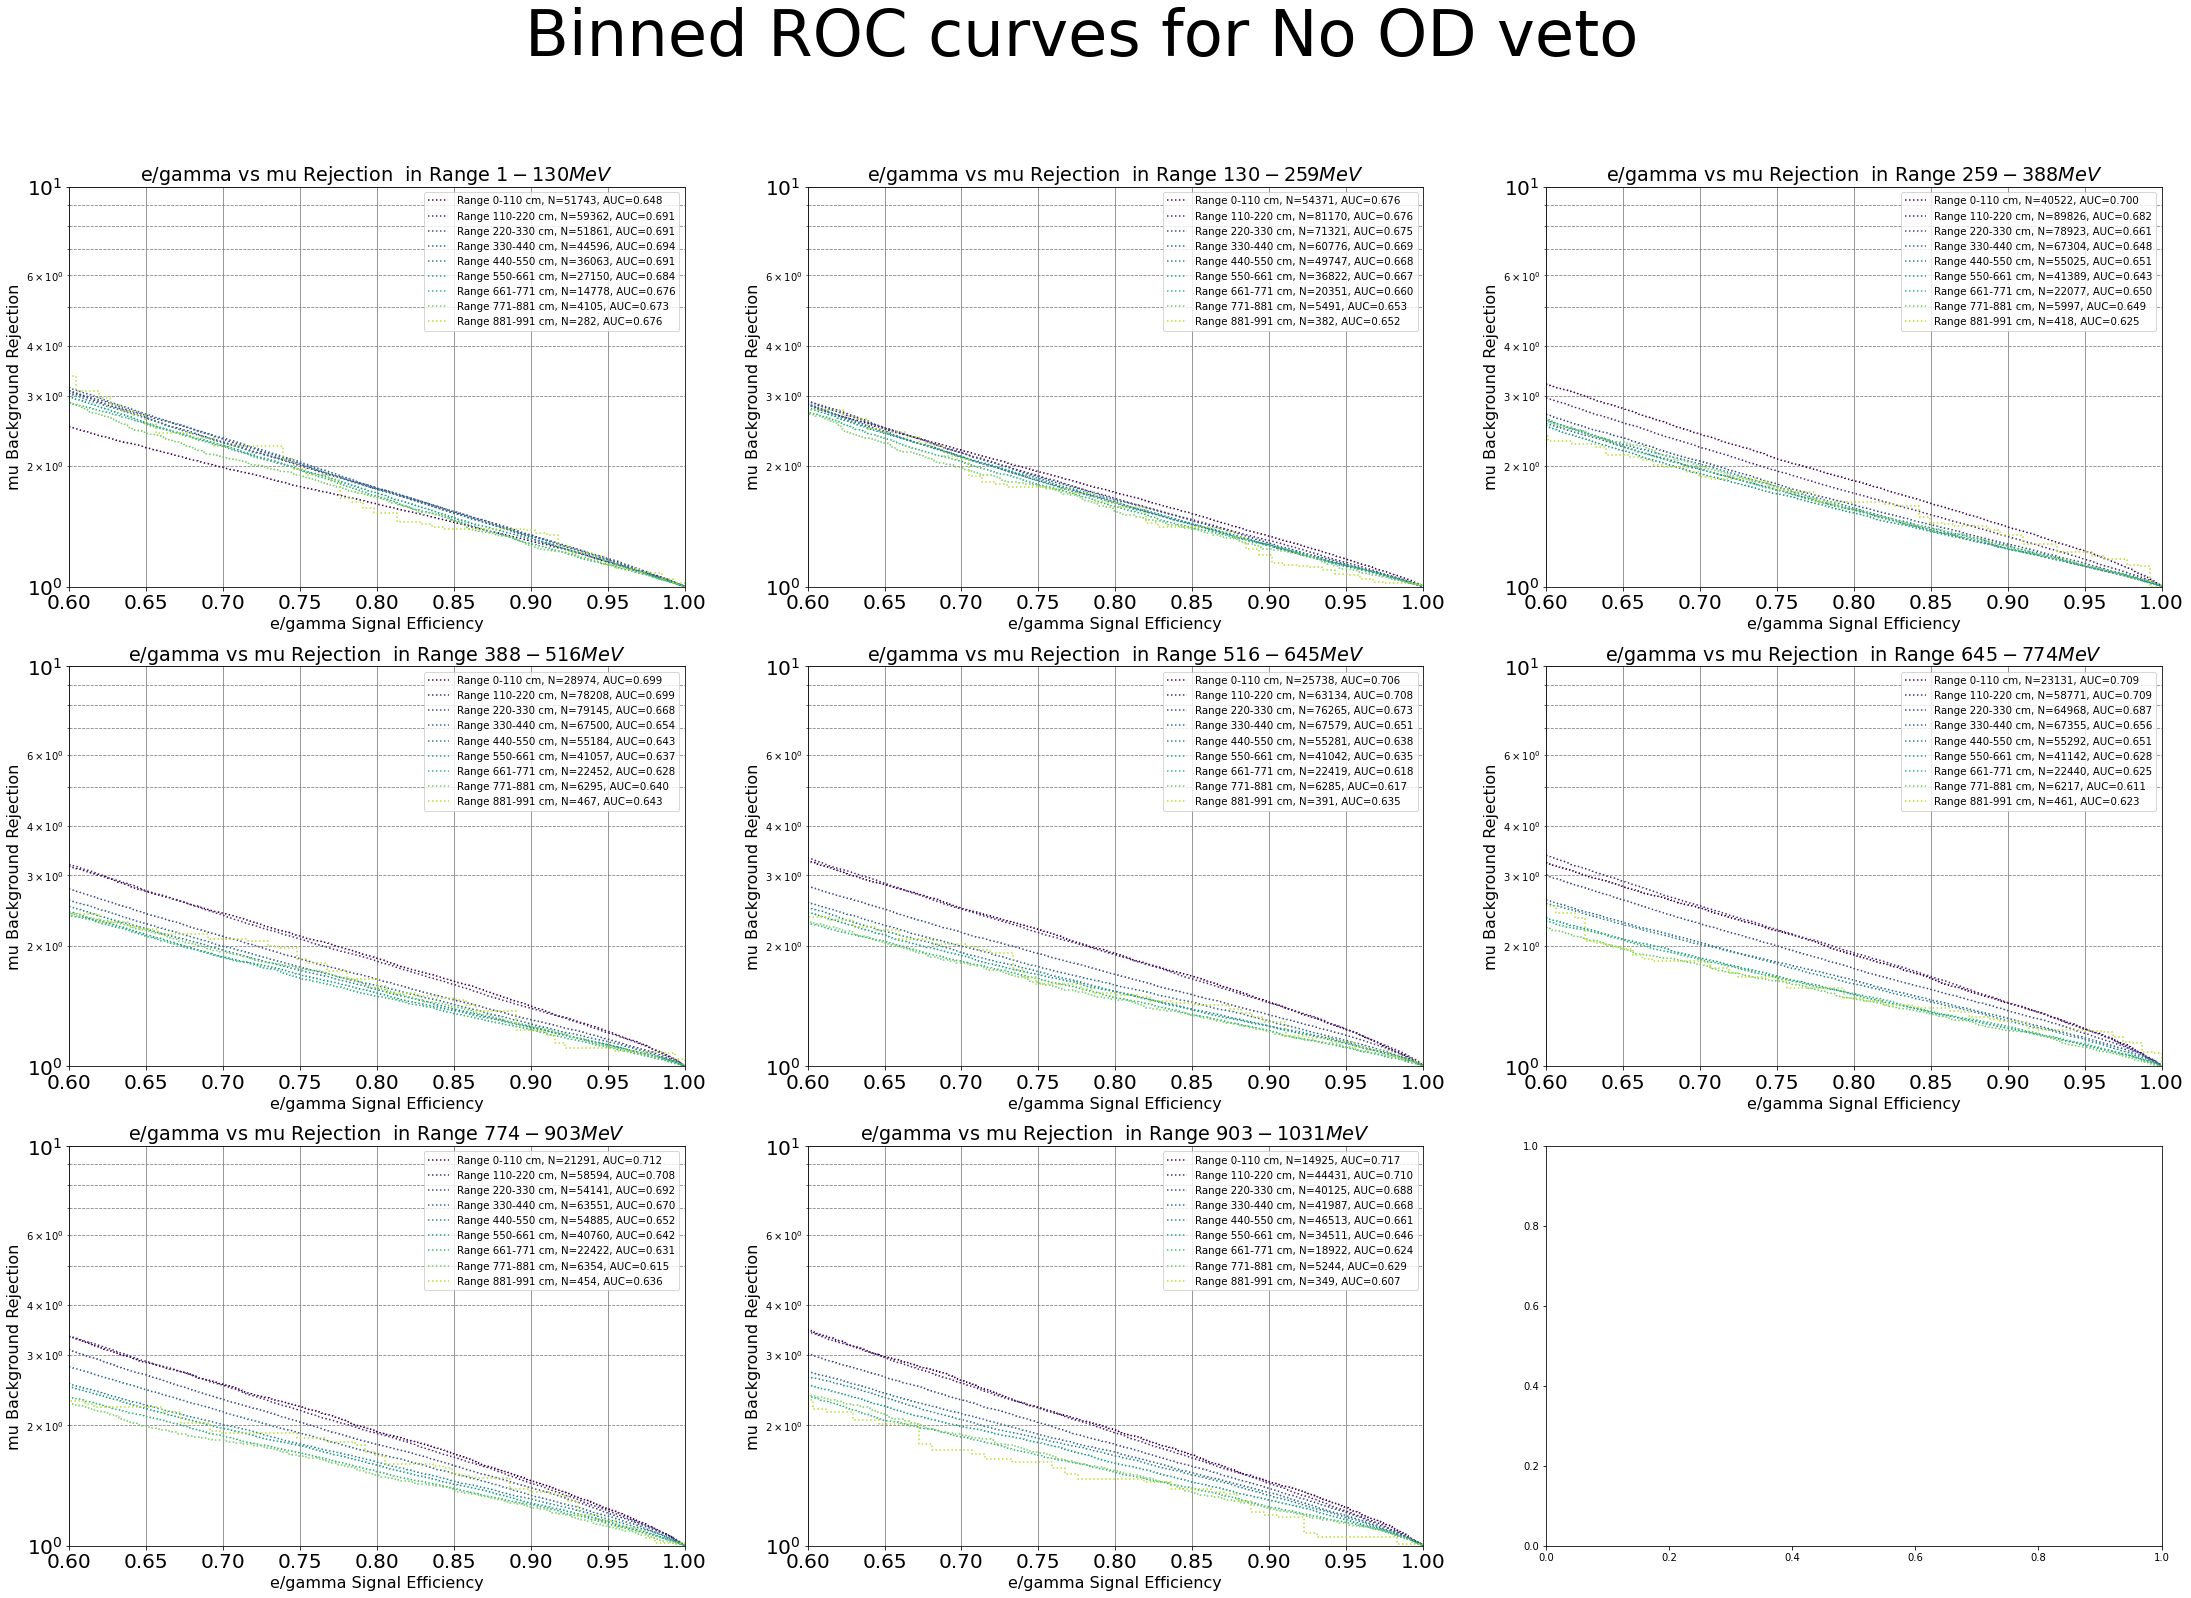

In [52]:
plot_binned_performance(subset_energies  = test_energies,
                        energy_bins      = energy_bins,
                        subset_d_to_wall = test_d_to_wall,
                        d_to_wall_bins   = d_to_wall_bins,
                        subset_softmax   = raw_output_softmax[0], 
                        subset_labels    = raw_actual_labels[0],
                        label_dict       = label_dict,
                        ignore_dict      = label_dict,
                        linecolor        = 'b',
                        line_title       = 'No OD veto',
                        threshold        = 2)

In [ ]:
plot_binned_performance(subset_energies  = test_energies,
                        energy_bins      = energy_bins,
                        subset_d_to_wall = test_d_to_wall,
                        d_to_wall_bins   = d_to_wall_bins,
                        subset_softmax   = raw_output_softmax[0], 
                        subset_labels    = raw_actual_labels[0],
                        label_dict       = muon_softmax_index_dict,
                        ignore_dict      = label_dict,
                        threshold        = 10,
                        muon_comparison  = True)

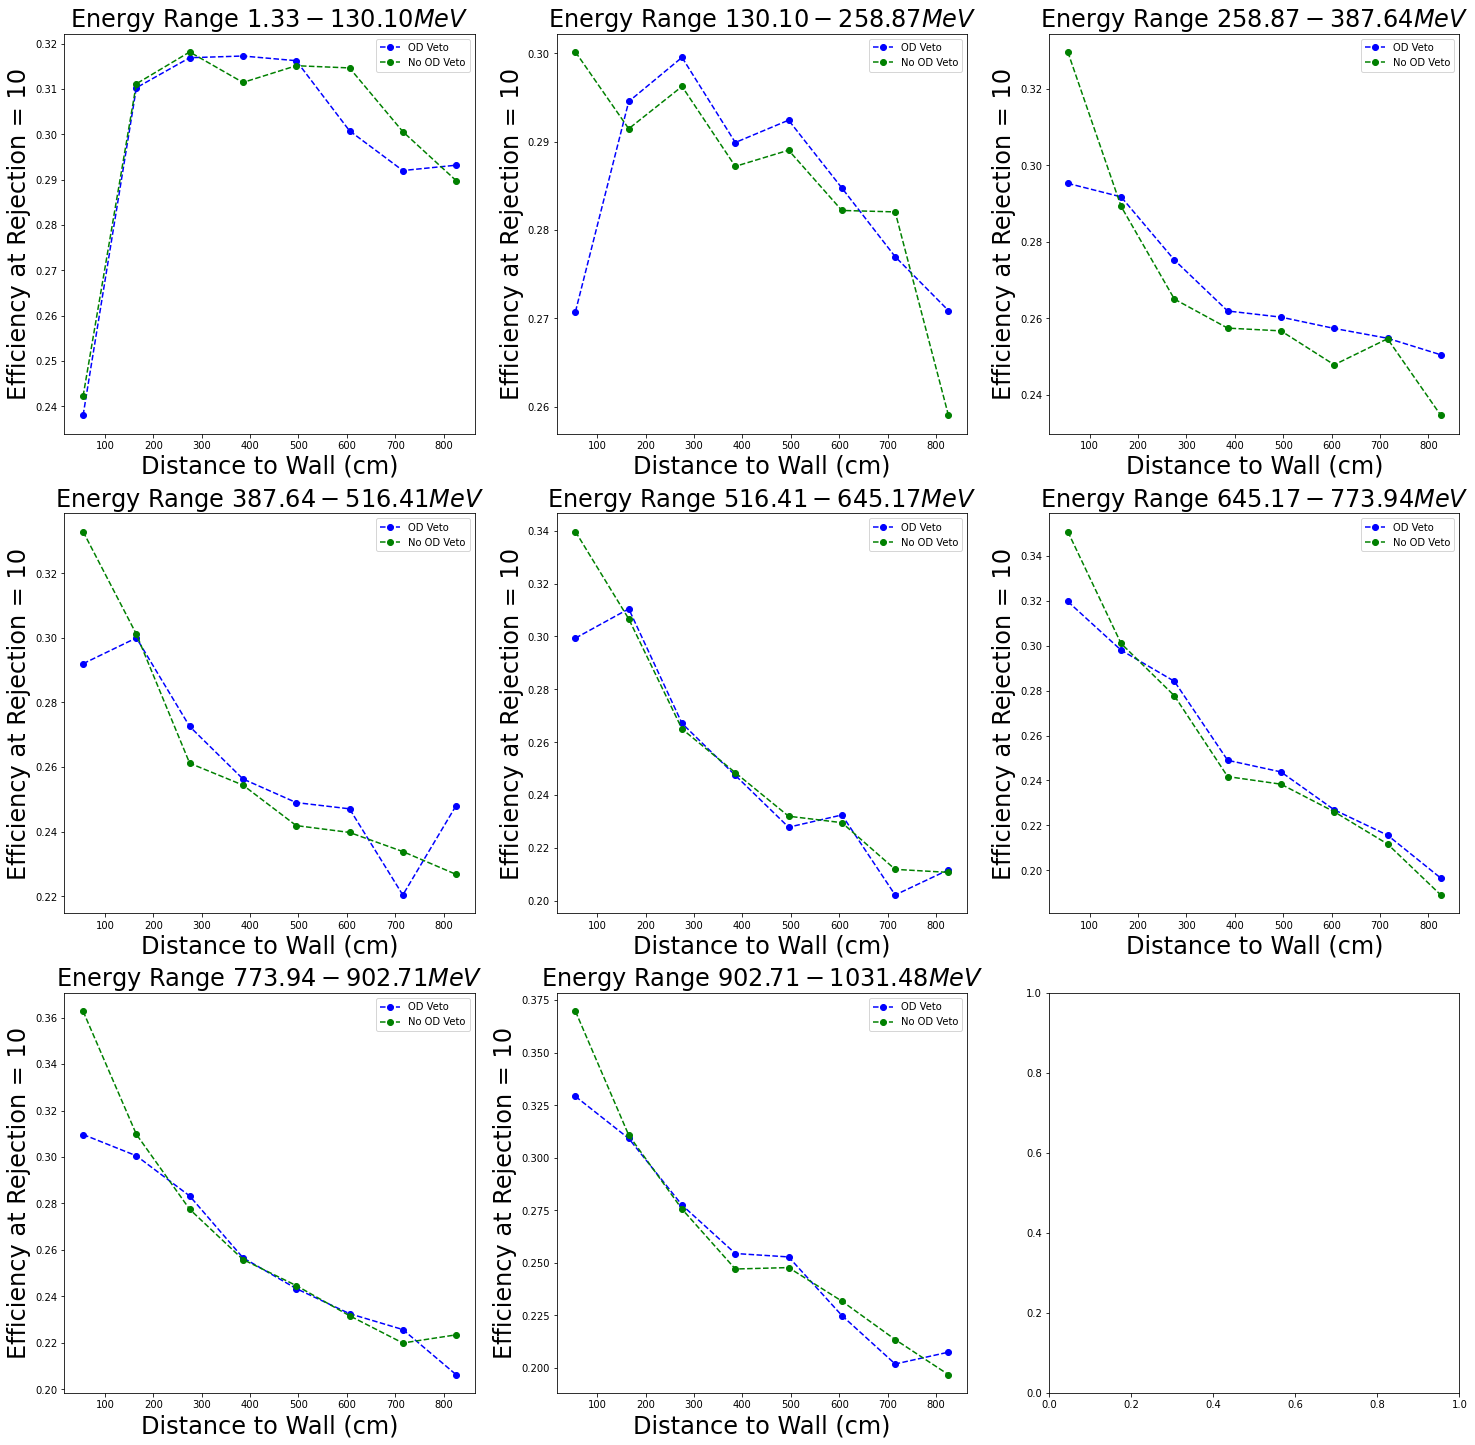

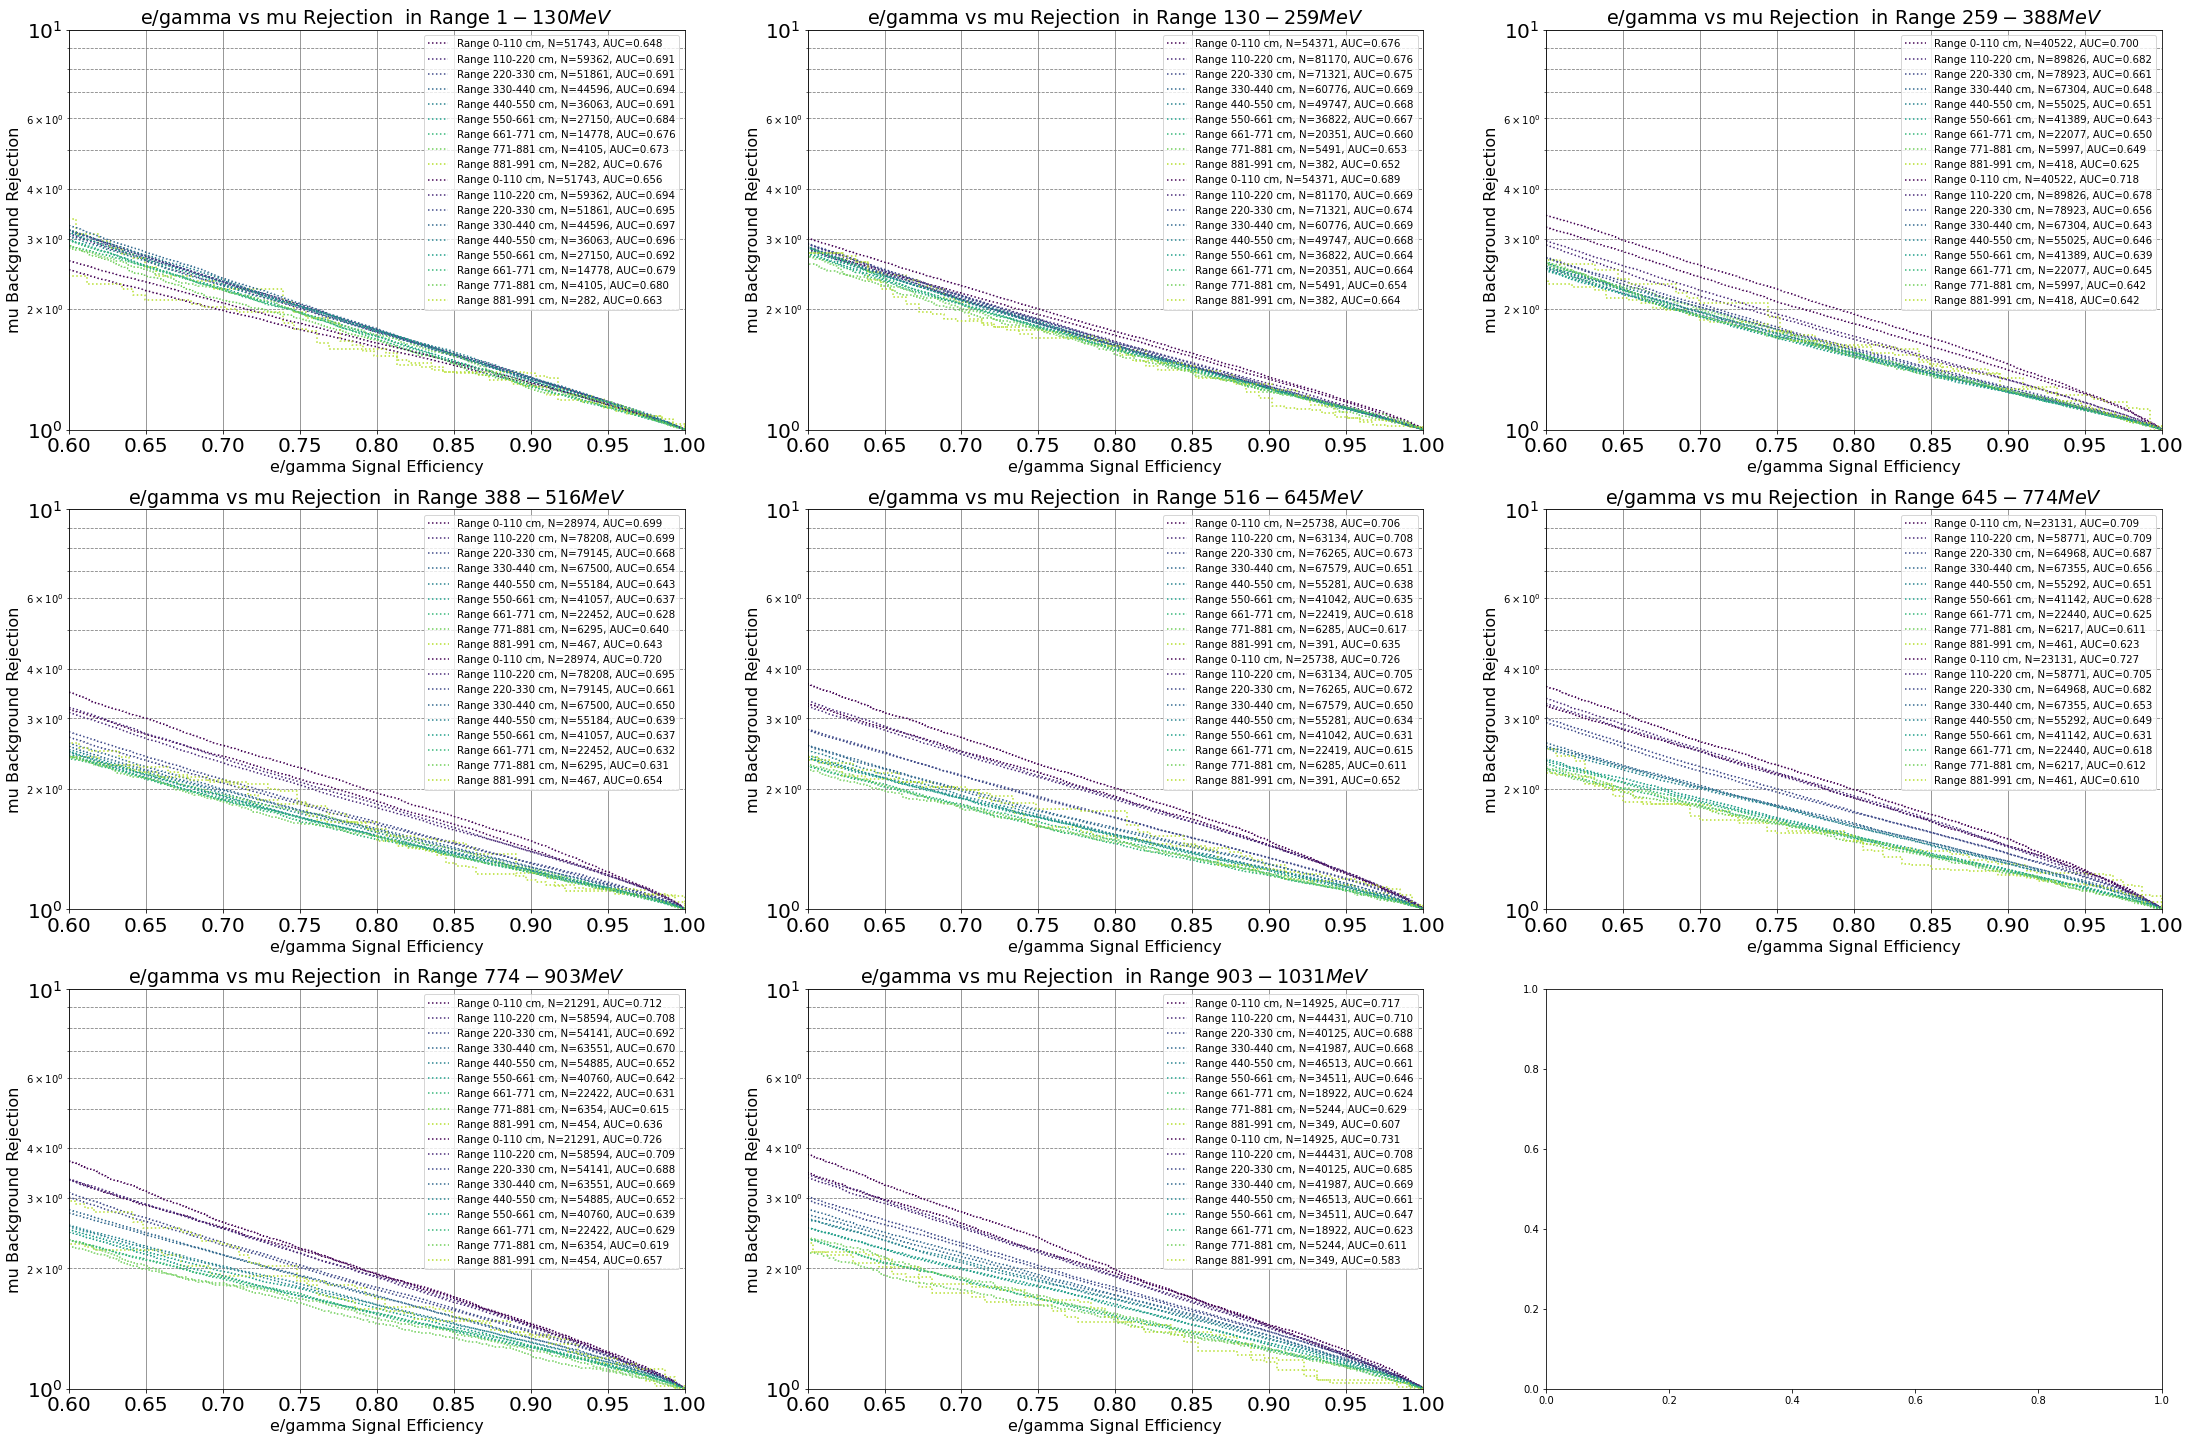

In [71]:
multi_plot_binned_performance(subset_energies    = test_energies,
                                energy_bins      = energy_bins,
                                subset_d_to_wall = test_d_to_wall,
                                d_to_wall_bins   = d_to_wall_bins,
                                subset_softmax_list   = raw_output_softmax, 
                                subset_labels_list    = raw_actual_labels,
                                label_dict       = label_dict,
                                ignore_dict      = label_dict,
                                threshold        = 10,
                                linecolors       = ['b', 'g'],
                                line_titles      = ['OD Veto', 'No OD Veto'],
                                muon_comparison  = False)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:805: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:805: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


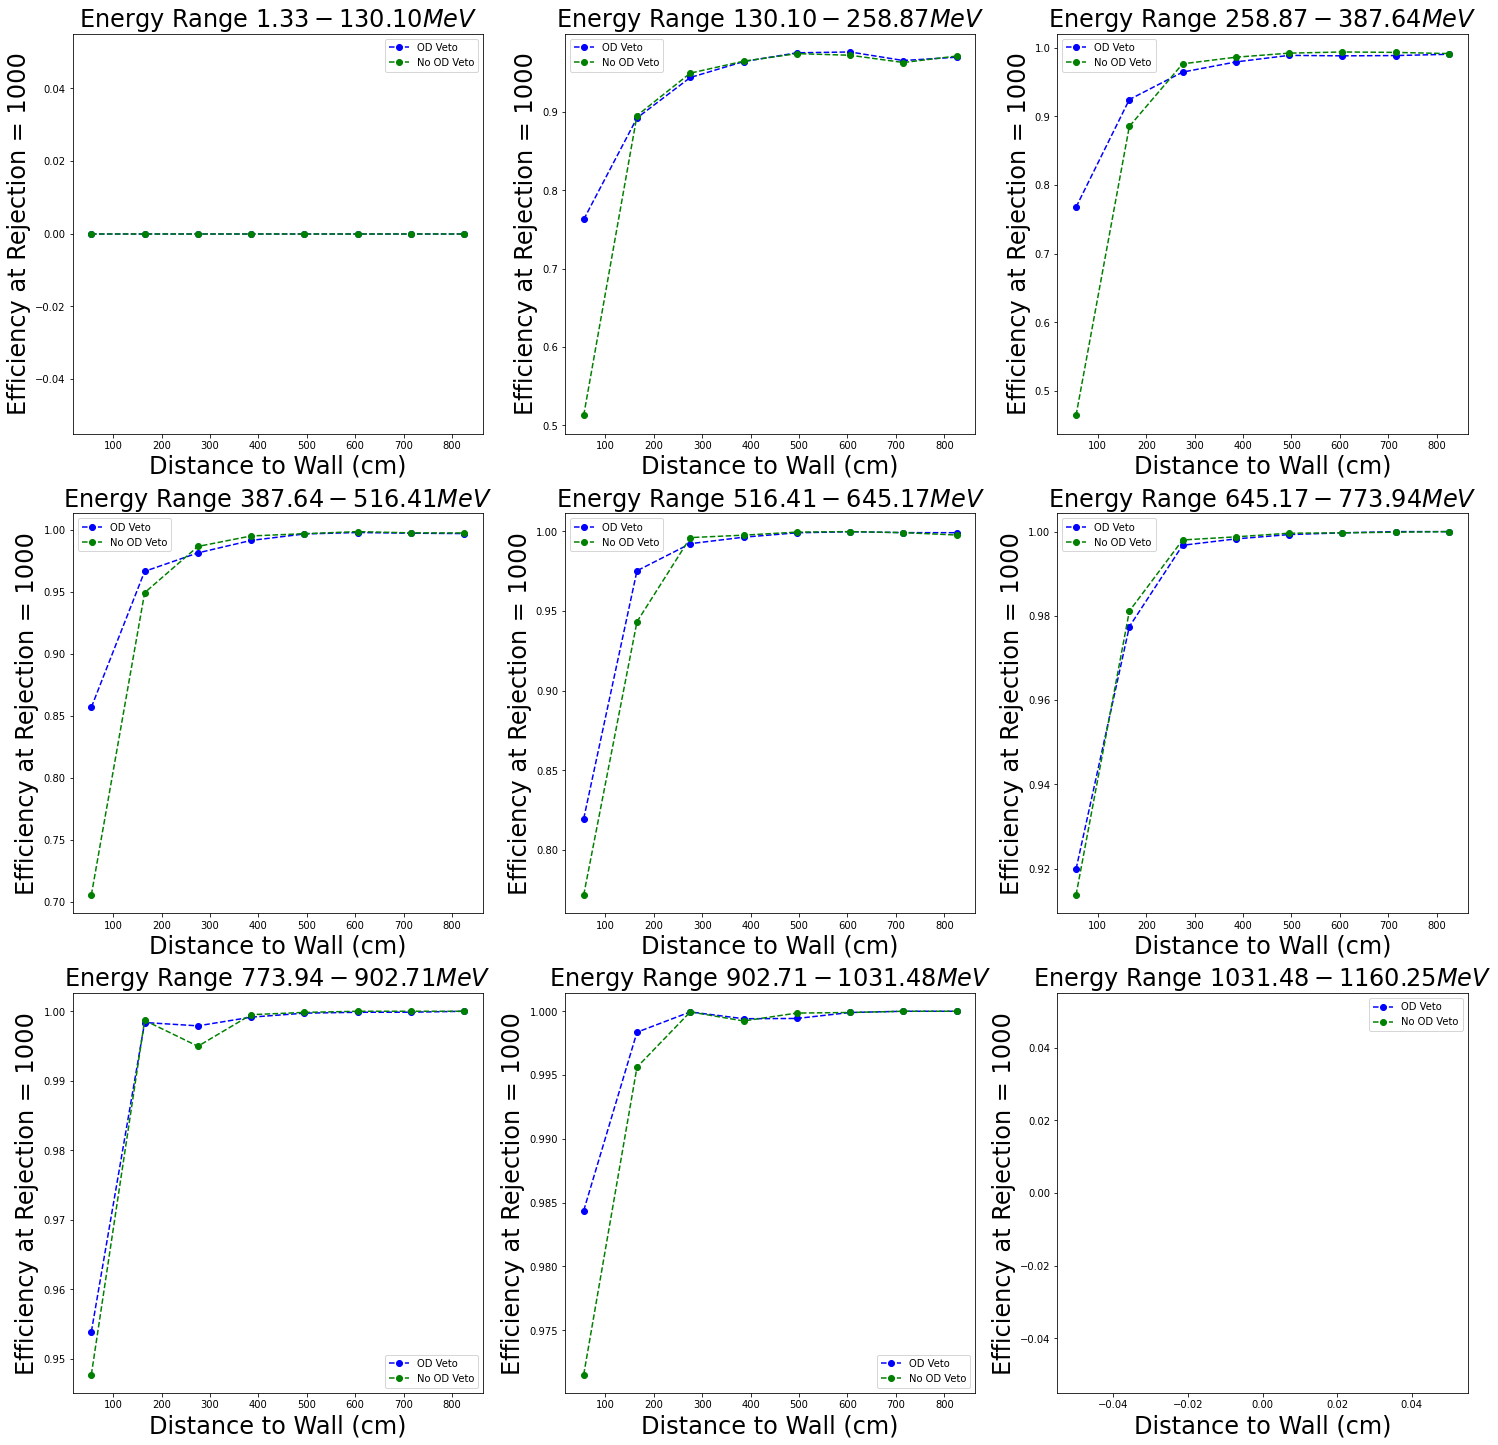

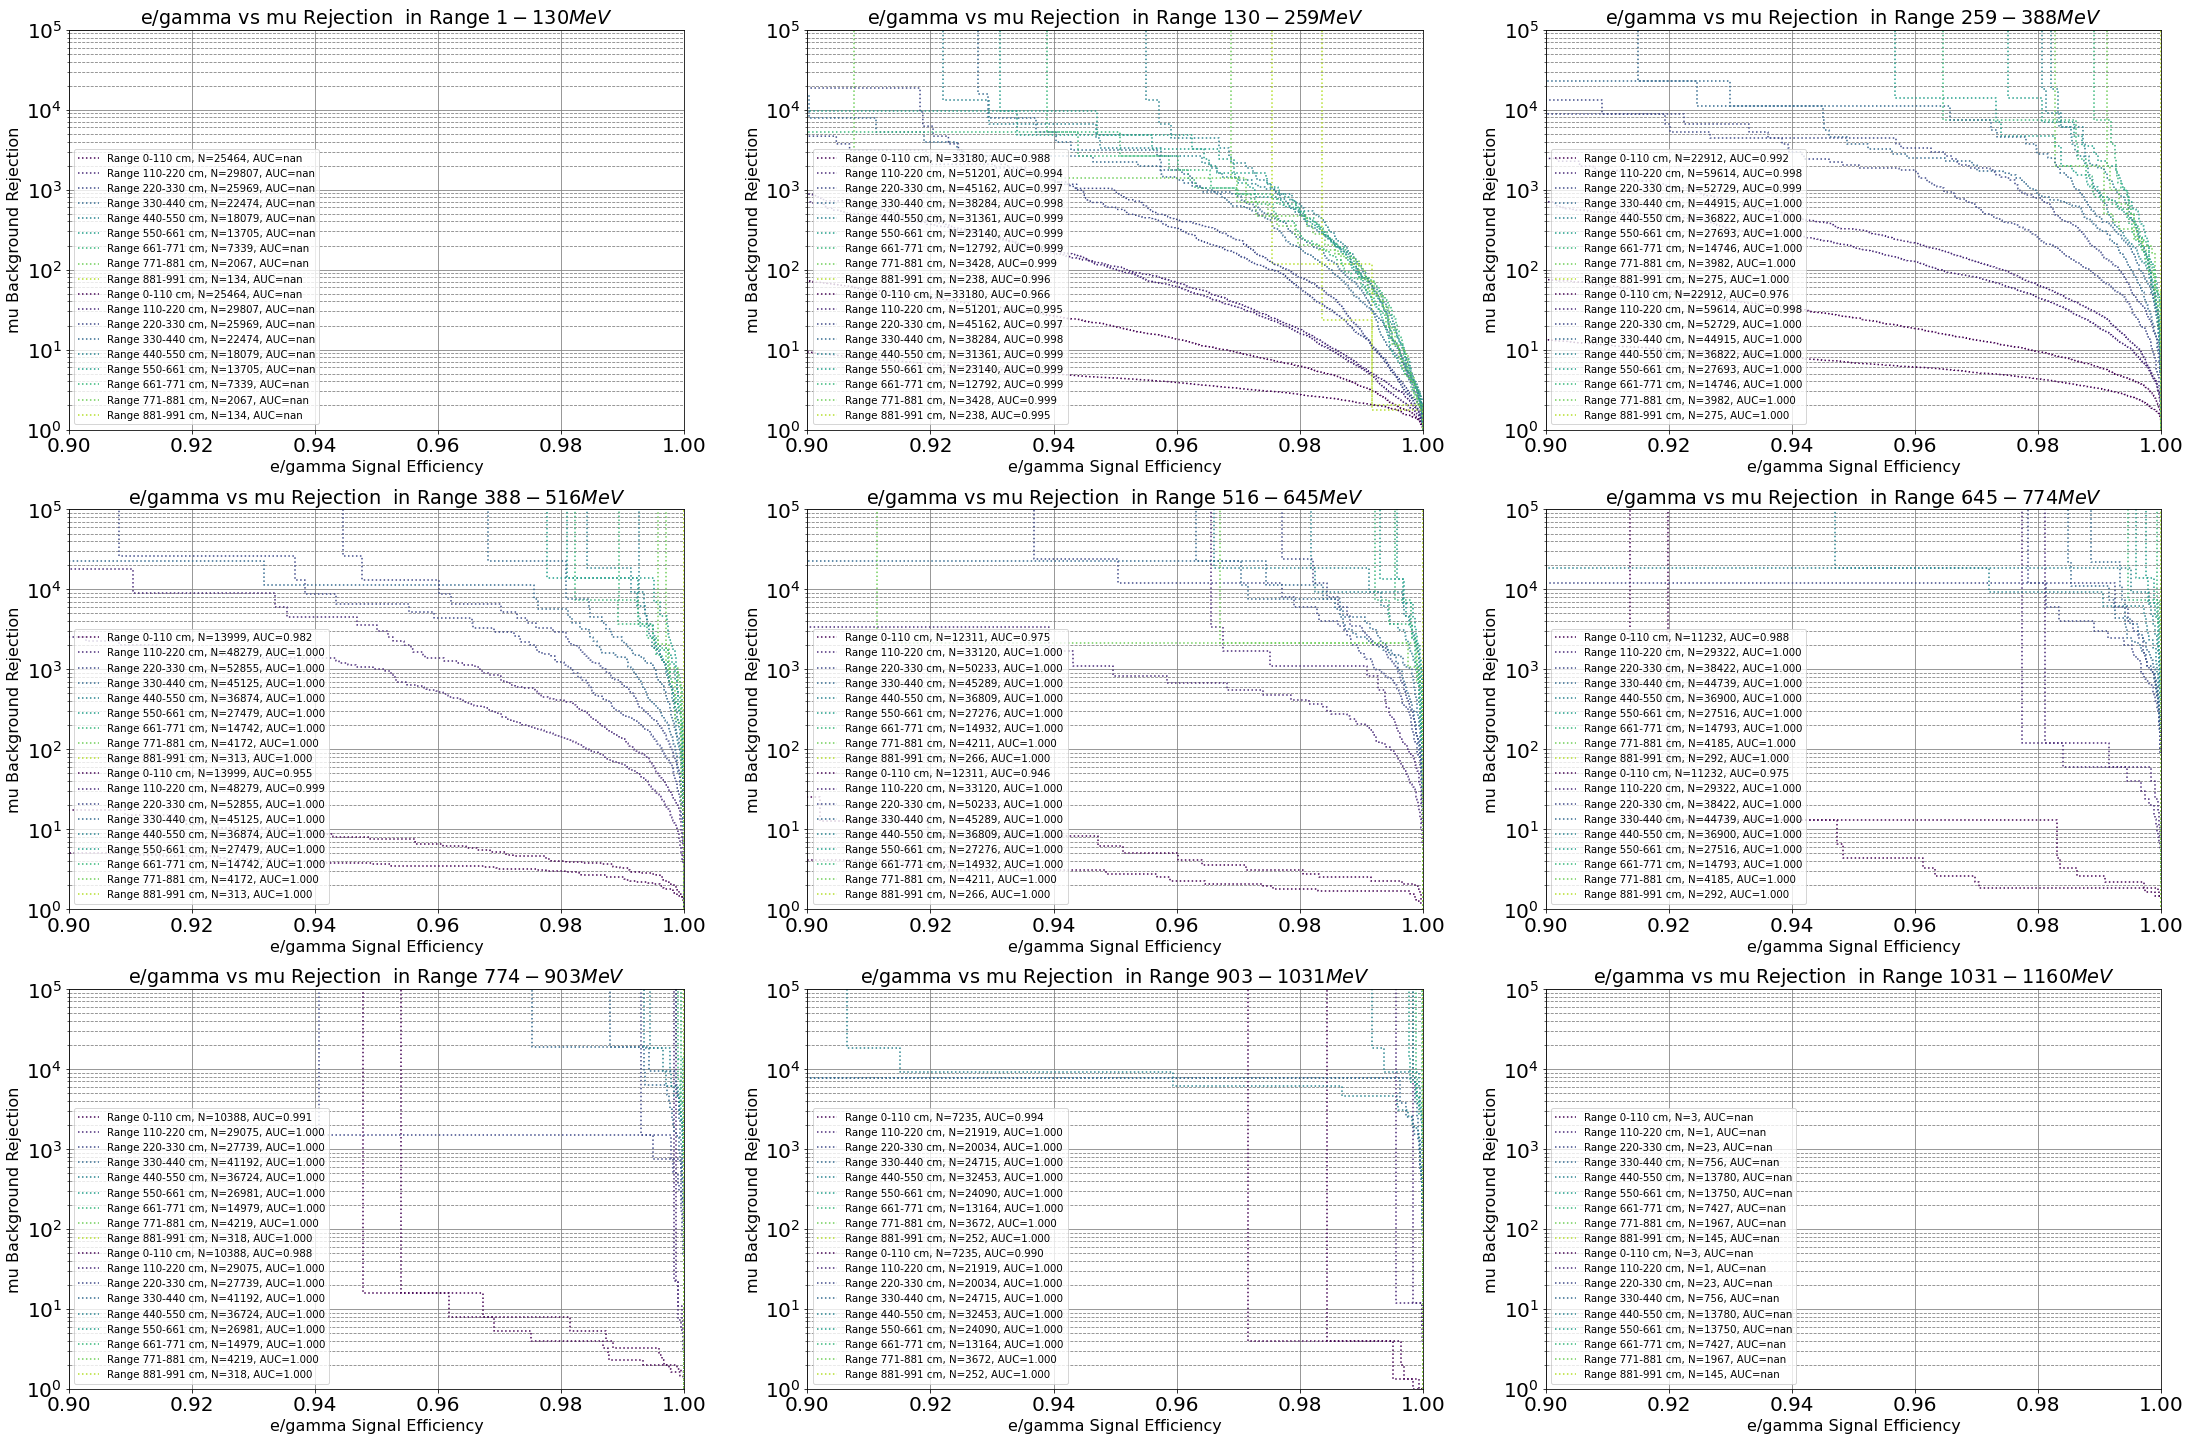

In [74]:
multi_plot_binned_performance(subset_energies    = test_energies,
                                energy_bins      = energy_bins,
                                subset_d_to_wall = test_d_to_wall,
                                d_to_wall_bins   = d_to_wall_bins,
                                subset_softmax_list   = raw_output_softmax, 
                                subset_labels_list    = raw_actual_labels,
                                label_dict       = muon_softmax_index_dict,
                                ignore_dict      = label_dict,
                                threshold        = 1000,
                                linecolors       = ['b', 'g'],
                                line_titles      = ['OD Veto', 'No OD Veto'],
                                muon_comparison  = True)

## Plot OD Veto Results

In [ ]:
plot_binned_performance(subset_energies  = test_energies,
                        energy_bins      = energy_bins,
                        subset_d_to_wall = test_d_to_wall,
                        d_to_wall_bins   = d_to_wall_bins,
                        subset_softmax   = raw_output_softmax[1], 
                        subset_labels    = raw_actual_labels[1],
                        label_dict       = label_dict,
                        ignore_dict      = label_dict,
                        threshold        = 2)

In [ ]:
plot_binned_performance(subset_energies  = test_energies,
                        energy_bins      = energy_bins,
                        subset_d_to_wall = test_d_to_wall,
                        d_to_wall_bins   = d_to_wall_bins,
                        subset_softmax   = raw_output_softmax[1], 
                        subset_labels    = raw_actual_labels[1],
                        label_dict       = muon_softmax_index_dict,
                        ignore_dict      = label_dict,
                        threshold        = 10,
                        muon_comparison  = True)

TypeError: 'NoneType' object is not subscriptable

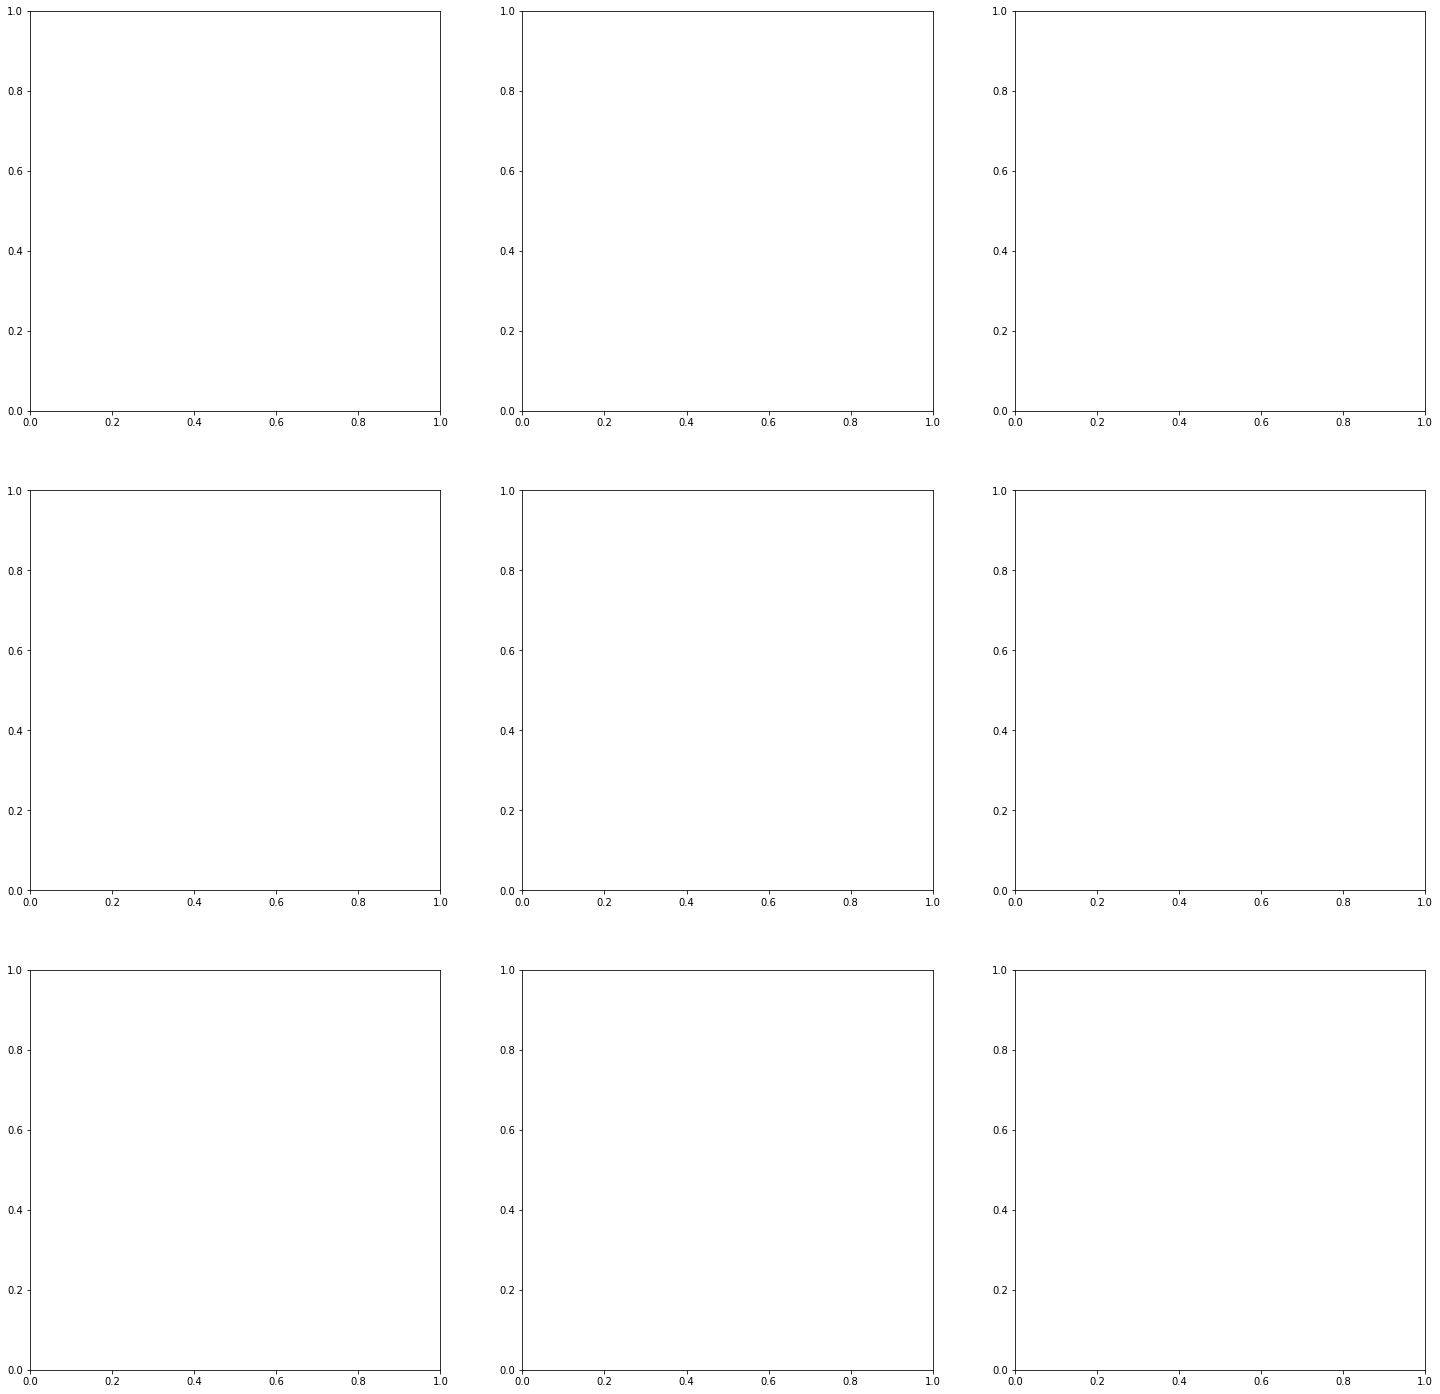

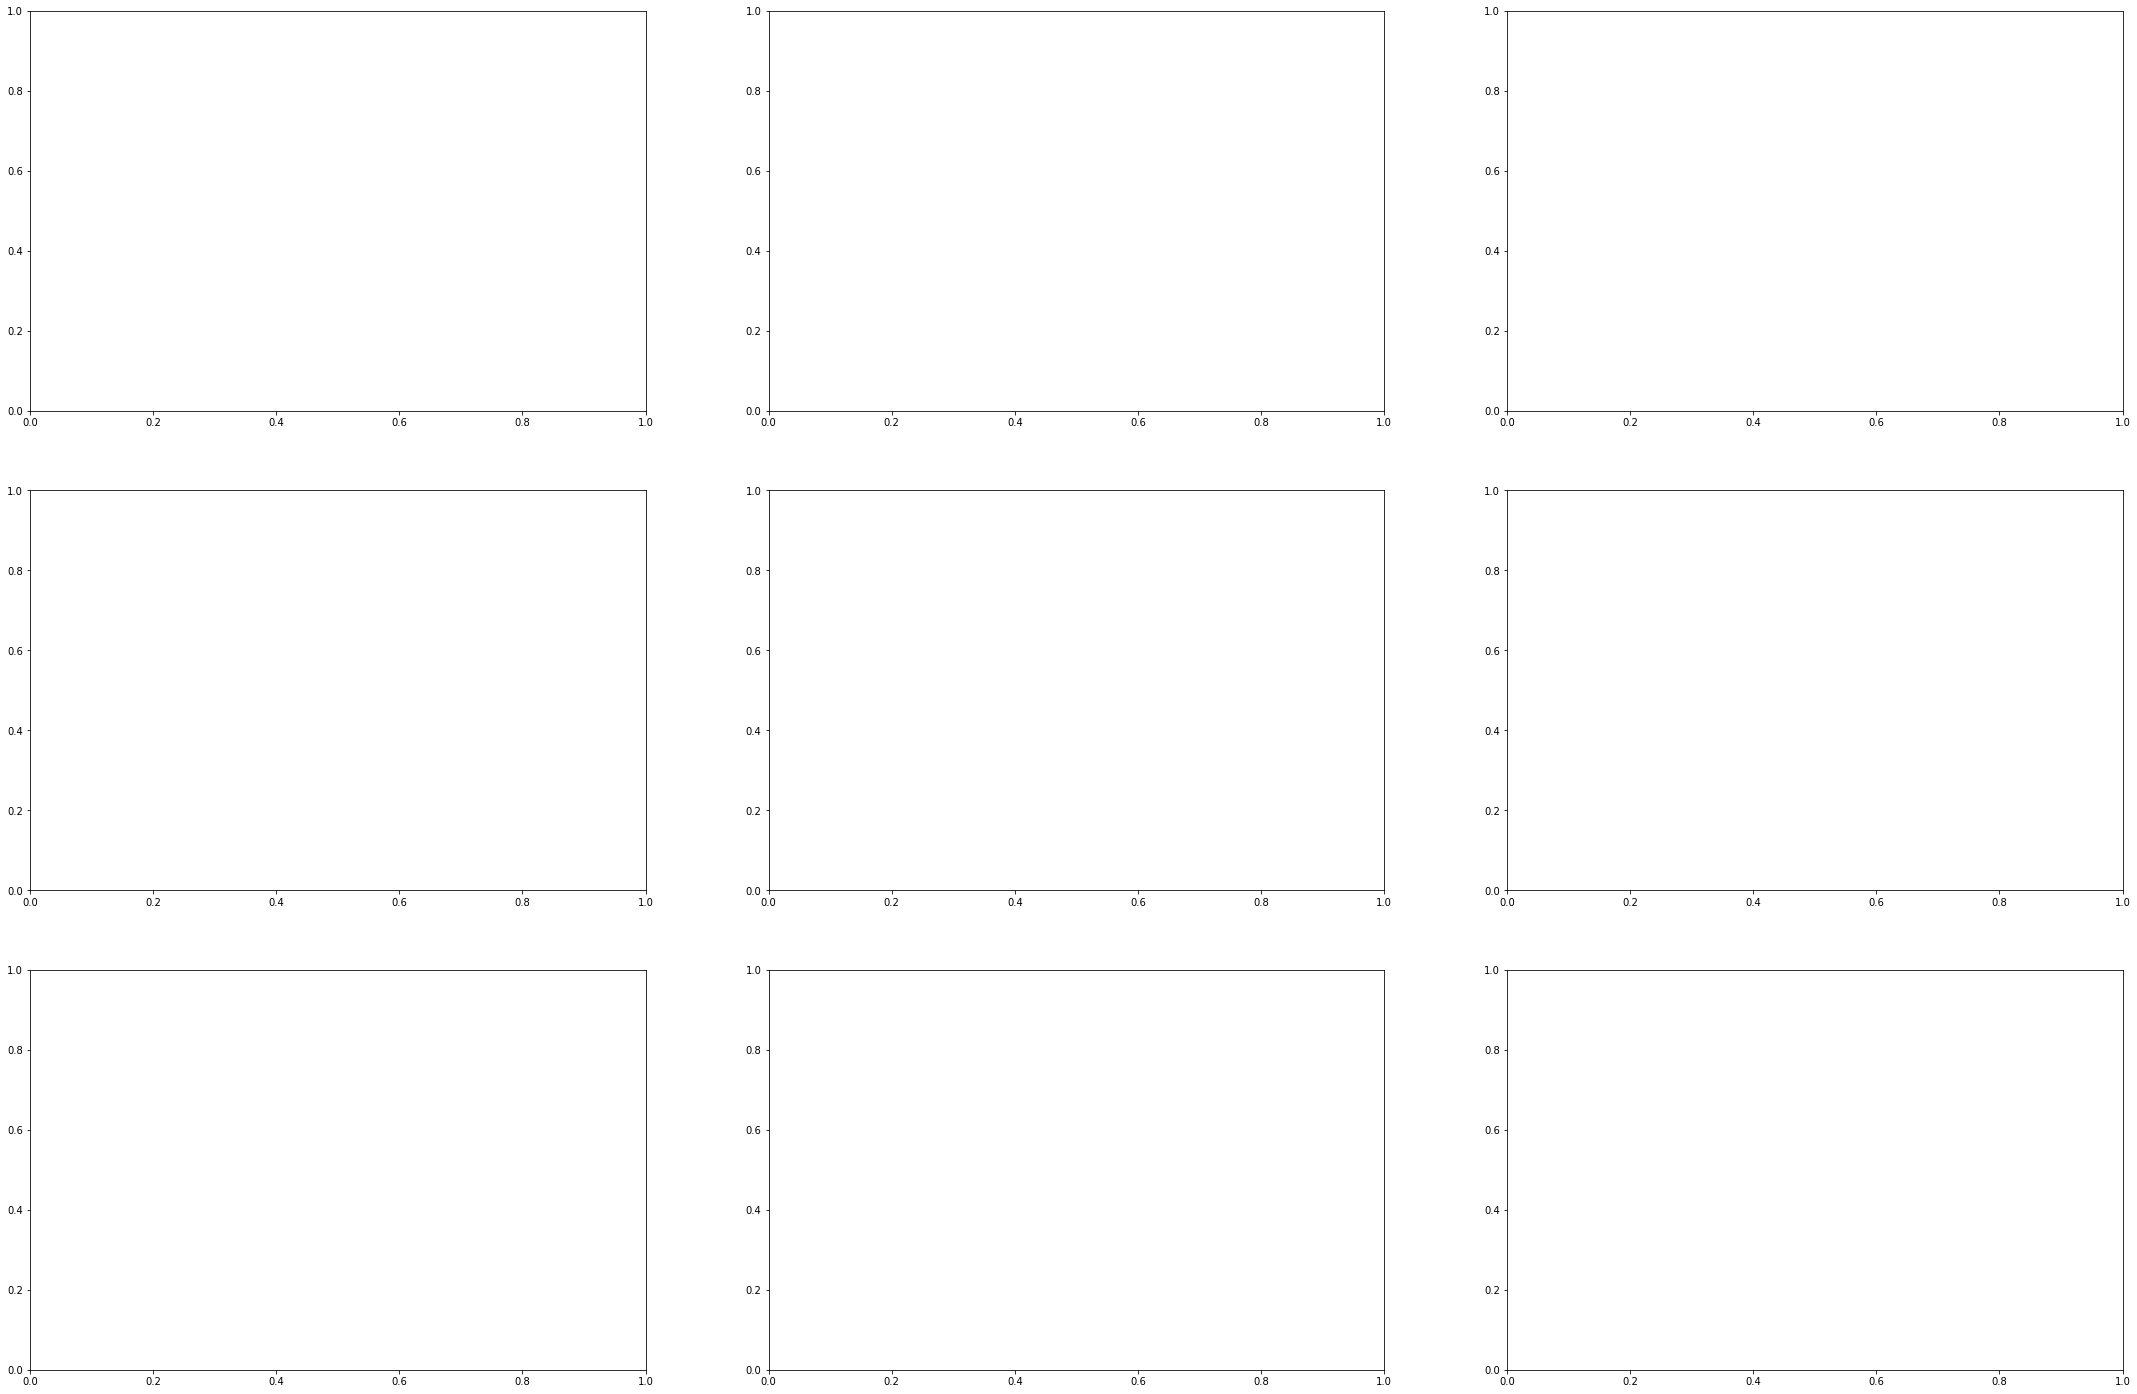

In [64]:
multi_plot_binned_performance(subset_energies     = test_energies,
                              energy_bins         = energy_bins,
                              subset_d_to_wall    = test_d_to_wall,
                              d_to_wall_bins      = d_to_wall_bins,
                              subset_softmax_list = raw_output_softmax, 
                              subset_labels_list  = raw_actual_labels,
                              label_dict          = label_dict,
                              ignore_dict         = label_dict,
                              threshold           = 2)

## binned performance

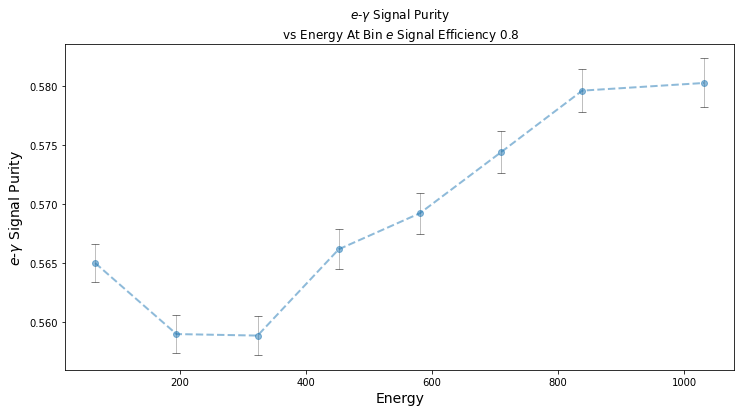

In [75]:
deprecated_plot_binned_performance(softmaxes = raw_output_softmax[0],
                                   labels    = raw_actual_labels[0],
                                   binning_features = test_energies,
                                   binning_label = 'Energy',
                                   efficiency    = 0.8,
                                   bins = energy_bins[:-1],
                                   index_dict = label_dict,
                                   label_0 = "$e$", 
                                   label_1 = "$\gamma$",
                                   metric='purity',
                                   fixed='rejection')

In [ ]:
deprecated_plot_binned_performance(softmaxes = raw_output_softmax[0],
                                   labels    = raw_actual_labels[0],
                                   binning_features = test_energies,
                                   binning_label = 'Energy',
                                   efficiency    = 0.8,
                                   bins = energy_bins[:-1],
                                   index_dict = label_dict,
                                   label_0 = "$e$", 
                                   label_1 = "$\gamma$",
                                   metric='purity',
                                   fixed='rejection',
                                   ax=None,
                                   marker='o--',
                                   color=None,
                                   legend_label_dict=None,
                                   title_note='')

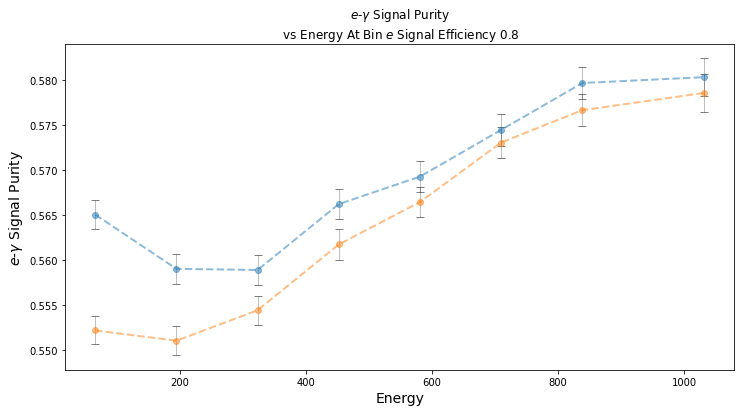

In [79]:
fig, ax = plt.subplots(figsize=(12,6), facecolor='w')
deprecated_plot_binned_performance(softmaxes        = raw_output_softmax[0],
                                   labels           = raw_actual_labels[0],
                                   binning_features = test_energies,
                                   binning_label    = 'Energy',
                                   efficiency       = 0.8,
                                   bins             = energy_bins[:-1],
                                   index_dict       = label_dict,
                                   label_0          = "$e$", 
                                   label_1          = "$\gamma$",
                                   metric           ='purity',
                                   ax               = ax,
                                   fixed            ='rejection')

deprecated_plot_binned_performance(softmaxes        = raw_output_softmax[1],
                                   labels           = raw_actual_labels[1],
                                   binning_features = test_energies,
                                   binning_label    = 'Energy',
                                   efficiency       = 0.8,
                                   bins             = energy_bins[:-1],
                                   index_dict       = label_dict,
                                   label_0          = "$e$", 
                                   label_1          = "$\gamma$",
                                   metric           ='purity',
                                   ax               = ax,
                                   fixed            ='rejection')

## fitqun binned performance

../../WatChMaL/analysis/performance_analysis_utils.py:279: RuntimeWarning: invalid value encountered in true_divide
  fprs = fps/(fps + tns)


(array([[370.99234],
        [854.1736 ],
        [455.36273],
        ...,
        [543.2171 ],
        [276.11942],
        [605.2046 ]], dtype=float32),
 array([0.7048226 , 0.01192778, 0.56782323, ..., 0.44139144, 0.73895359,
        0.22678851]))

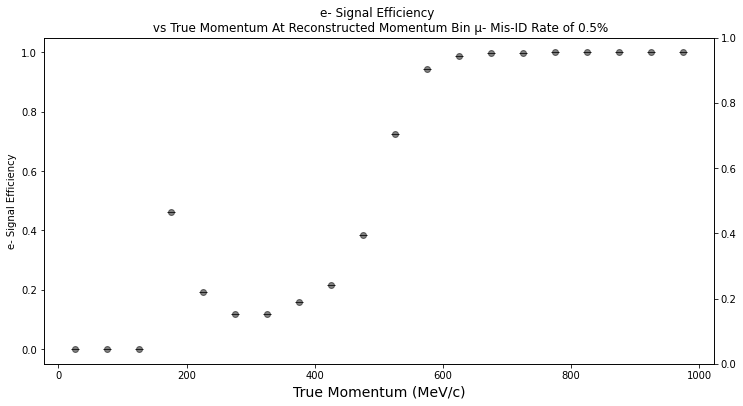

In [76]:
deprecated_plot_fitqun_binned_performance(scores                 = raw_output_softmax[0][:,1], 
                                          labels                 = raw_actual_labels[1], 
                                          true_momentum          = test_energies, 
                                          reconstructed_momentum = test_energies, 
                                          fpr_fixed_point        = 0.005, 
                                          index_dict             = label_dict, 
                                          recons_mom_bin_size    = 50, 
                                          true_mom_bins          = 20, 
                                          ax                     = None,
                                          marker                 = 'o',
                                          color                  = 'k',
                                          title_note             = '',
                                          metric                 = 'efficiency',
                                          yrange                 = None)